In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras import applications
SEED = 2020

import random
import os

In [28]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'dataset/train/',
    labels='inferred',
    label_mode='categorical',
    # label_mode='int',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=64,
    # shuffle=True,
    # seed = SEED,
)
ds_valid_ = image_dataset_from_directory(
    'dataset/test/',
    labels='inferred',
    label_mode='categorical',
    # label_mode='int',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=64,
    # shuffle=False,
    # seed = SEED,
)

AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train_.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid_.cache().prefetch(buffer_size=AUTOTUNE)


# Data Pipeline
# def convert_to_float(image, label):
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#     return image, label

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# ds_train = (
#     ds_train_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )
# ds_valid = (
#     ds_valid_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )




y_true = np.concatenate([y for x, y in ds_valid], axis=0)
URL = "https://tfhub.dev/google/imagenet/inception_v1/classification/5"
pretrained_base = hub.KerasLayer(URL,input_shape = (224, 224, 3))
# pretrained_base = applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3)) # https://keras.io/api/applications/
pretrained_base.trainable = False
# for layer in pretrained_base.layers:
#     layer.trainable = False




print('Done!')

Found 21693 files belonging to 21 classes.
Found 4280 files belonging to 21 classes.
Done!


In [11]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal",input_shape=(224, 224, 3)),
#     layers.RandomRotation(0.2),
#     preprocessing.RandomZoom(
#     height_factor = 0.2,
#     width_factor = -0.3,
#     fill_mode = "constant",
#     interpolation = "bilinear"),
# ])

model = tf.keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    # preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.10),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    # preprocessing.RandomZoom(
    #     height_factor = 0.2,
    #     width_factor = -0.3,
    #     fill_mode = "constant",
    #     interpolation = "bilinear"),
    # data_augmentation,
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    pretrained_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    # layers.Dense(256, activation='relu'),
    # layers.Dropout(0.5),
    # tf.keras.layers.Dense(21,kernel_regularizer='l1_l2', activation='sigmoid'),
    tf.keras.layers.Dense(21, activation='sigmoid'),



])


optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'categorical_crossentropy',
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)

# print(model.summary())

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                            patience=1, verbose=1, min_lr=0.00001)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[rlronp, callbacks],
)

#model.evaluate(ds_valid)

Epoch 1/50
339/339 [==============================] - 3899s 12s/step - loss: 0.9183 - accuracy: 0.7242 - val_loss: 0.6300 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 2/50
339/339 [==============================] - 3971s 12s/step - loss: 0.4727 - accuracy: 0.8526 - val_loss: 0.5672 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 3/50
339/339 [==============================] - 3927s 12s/step - loss: 0.3746 - accuracy: 0.8844 - val_loss: 0.5346 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 4/50
339/339 [==============================] - 3460s 10s/step - loss: 0.3140 - accuracy: 0.9043 - val_loss: 0.4972 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 5/50
339/339 [==============================] - 3381s 10s/step - loss: 0.2653 - accuracy: 0.9167 - val_loss: 0.4691 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 6/50
339/339 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9291
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
339/339 [=============================

In [13]:
model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = -20

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'categorical_crossentropy',
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)

# print(model.summary())

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                            patience=1, verbose=1, min_lr=0.00001)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[rlronp, callbacks],
)

Epoch 1/50
339/339 [==============================] - 13874s 41s/step - loss: 0.6709 - accuracy: 0.8698 - val_loss: 0.8703 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 2/50
339/339 [==============================] - 15227s 45s/step - loss: 0.3674 - accuracy: 0.9635 - val_loss: 0.7727 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 3/50
339/339 [==============================] - 14091s 42s/step - loss: 0.3039 - accuracy: 0.9828 - val_loss: 0.7011 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 4/50
339/339 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.9901 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
339/339 [==============================] - 13279s 39s/step - loss: 0.2828 - accuracy: 0.9901 - val_loss: 1.0105 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 5/50
339/339 [==============================] - 14227s 42s/step - loss: 0.2653 - accuracy: 0.9947 - val_loss: 0.6911 - val_accuracy: 0.9164 - lr: 5.0000e-04
Epoch 6/50
339/339 [===================

,loss,accuracy,val_loss,val_accuracy,lr
0,0.670907,0.869774,0.870256,0.845301,0.001000
1,0.367377,0.963537,0.772722,0.885362,0.001000
2,0.303942,0.982805,0.701146,0.897203,0.001000
3,0.282841,0.990135,1.010466,0.859662,0.001000
4,0.265278,0.994699,0.691086,0.916352,0.000500
5,0.255240,0.997372,0.690358,0.920383,0.000500
6,0.251869,0.998571,0.729831,0.922399,0.000500
7,0.249971,0.999078,0.727504,0.921139,0.000250
8,0.248666,0.999355,0.725310,0.923154,0.000125


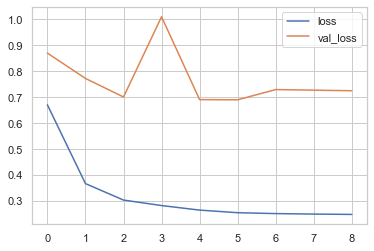

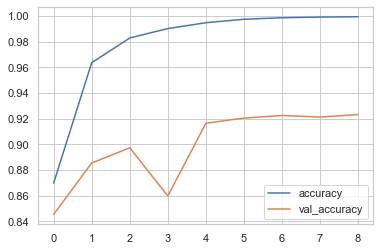

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_frame

In [15]:
# model.save('final_model_923.h5')

In [ ]:
stop

In [32]:
y_true.argmax(axis=0)

22

In [29]:
print(classification_report(y_true.argmax(axis=1),model.predict(ds_valid).argmax(axis=-1)))

# print(classification_report(y_true,model.predict(ds_valid).argmax(axis=-1)))

67/67 [==============================] - 268s 4s/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.95      0.87      0.91       200
           2       0.96      0.99      0.98       185
           3       0.87      0.94      0.90       191
           4       0.99      1.00      1.00       200
           5       0.91      0.85      0.88       194
           6       0.88      0.97      0.93       194
           7       0.97      0.97      0.97       200
           8       0.97      0.93      0.95       201
           9       0.98      0.93      0.95       163
          10       0.86      0.92      0.89       186
          11       0.90      0.78      0.84       245
          12       0.97      0.99      0.98       195
          13       0.97      0.90      0.93       175
          14       0.91      0.86      0.88       458
          15       0.83      0.96      0.89       200
          16       0.92    

In [269]:
from tensorflow.keras.preprocessing import image
from scipy.special import softmax
class_names = np.array(ds_train_.class_names)
HEIGHT = 224
WIDTH = 224
# model = tf.keras.models.load_model(
#        ('final_model.h5'),
#        custom_objects={'KerasLayer':hub.KerasLayer}
# )
img_dir='dataset/validation/all'
batch_holder = np.zeros((len(os.listdir(img_dir)), HEIGHT, WIDTH, 3))
for i,img in enumerate(os.listdir(img_dir)):

  img = image.load_img(os.path.join(img_dir,img), target_size=(HEIGHT, WIDTH))
  img_tensor = image.img_to_array(img)                    # (height, width, channels)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
  # img_tensor /= 255.   
  batch_holder[i, :] = img_tensor

model = tf.keras.models.load_model(
       ('final_model_923.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

predictions = model.predict(batch_holder)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

result = pd.DataFrame()
result['imageName'] = os.listdir(img_dir)
result['type1'] = np.nan
result['type2'] = np.nan
result['type3'] = np.nan
t = 0

for i in predictions:


  result['type1'][t] = class_names[i.argsort()[-1]]
  result['type2'][t] = class_names[i.argsort()[-2]]
  result['type3'][t] = class_names[i.argsort()[-3]]
  t+=1
    # print(
    # "This image most likely belongs to {} with a {:.2f} percent confidence."
    # .format(class_names[np.argmax(tf.nn.softmax(i))], 100 * np.max(tf.nn.softmax(i)))
    # )
result
  


1/1 [==============================] - 3s 3s/step


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_3116\2255945470.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['type1'][t] = class_names[i.argsort()[-1]]
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_3116\2255945470.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['type2'][t] = class_names[i.argsort()[-2]]
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_3116\2255945470.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

,imageName,type1,type2,type3
0,attic_1201.jpg,attic,play,foyer
1,basement_1237.jpg,foyer,living,play
2,bathroom_1201.jpg,bath,living,laundry
3,bedroom_1204.jpg,bed,sunroom,gym
4,deck_1204.jpg,deck,garage,patio
5,dinning_1201.jpg,dinning,wine,kitchen
6,foyer_1201.jpg,foyer,wine,deck
7,gameroom_1202.jpg,game,play,gym
8,garage_1204.jpg,sunroom,patio,play
9,gym_1201.jpg,gym,play,foyer


In [204]:
class_names

array(['attic', 'basement', 'bath', 'bed', 'deck', 'dinning', 'foyer',
       'game', 'garage', 'gym', 'homeoffice', 'kitchen', 'laundry',
       'library', 'living', 'patio', 'play', 'pool', 'storage', 'sunroom',
       'wine'], dtype='<U10')

In [185]:
predictions[0].round(2)

array([0.1 , 1.  , 1.  , 0.94, 0.03, 0.01, 0.  , 0.01, 0.96, 0.15, 0.03,
       0.  , 0.99, 0.01, 0.01, 0.3 , 0.  , 0.31, 0.25, 0.  , 0.02],
      dtype=float32)